# OpenAI APIでEmbeddings評価
- OpenAI.embeddings.createを使用してEmbedding
- 1件ずつEmbedding
- 散布図と評価スコアの作成

## Embeddings

In [4]:
import time
import subprocess
import numpy as np
import pandas as pd
from openai import OpenAI

## GPUメモリ表示
def gpu_mem():
    gpucmd = 'nvidia-smi --query-gpu=memory.used --format=csv,,noheader'
    gpuinfo = subprocess.check_output(gpucmd, shell=True)
    return 'GPU memory: ' + gpuinfo.decode()

## 設定
model = 'text-embedding-ada-002' ## LLM Model Name
title = 'Qwen/Qwen2-0.5B' + ' fastchat' ## グラフタイトル
datafile = '../livedoor_300.csv.zip' ## Datasets file

## データ読み込み
df_livedoor = pd.read_csv(datafile)
text_data = list(df_livedoor['content512'].values)

## モデルの読み込み
client = OpenAI(
    base_url='http://localhost:8000/v1', ## API Endpoint
    api_key='Dummy', ## Dummy Key
)

## 試験
response = client.embeddings.create(
    model=model,
    timeout = 3600,
    input=['hello world']
)
print('Embed len:', len(response.data[0].embedding))

## Embedding
start = time.perf_counter()
embed_data = []
i=0
for text in text_data:
    response = client.embeddings.create(
        model=model,
        timeout = 3600*8,
        input=text
    )
    embed_data.append(response.data[0].embedding)

print('embeded time:', time.perf_counter() - start)
print(gpu_mem()) ## GPUメモリ消費量


Embed len: 896
embeded time: 871.3392138280906
GPU memory: 8440 MiB
148 MiB
148 MiB



## 散布図の作成
- t-SNEで2次に次元元削減して散布図を作成  
- 評価方法  
ライブドアニュース（9カテゴリ、300件ずつ、計2700件）、EmbeddingsのCos類似度で、上位3件が同じカテゴリかどうか、同じカテゴリ数/全カテゴリ数 = 100点満点

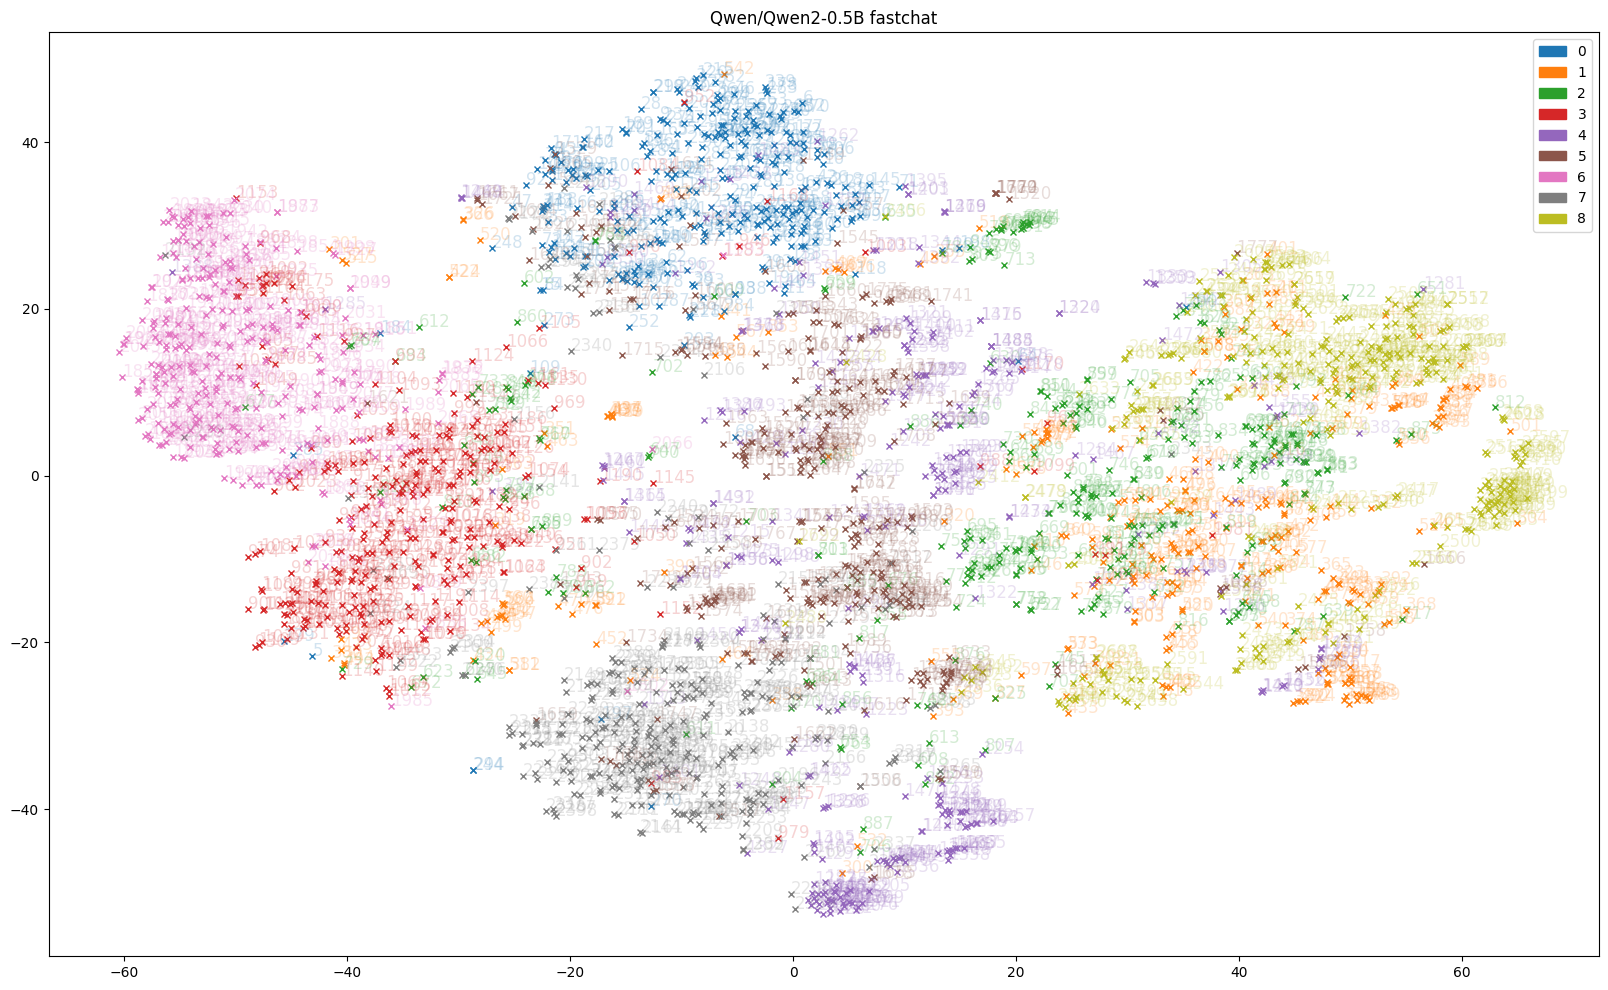

Score: 0.7398765432098765


In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from pylab import rcParams
fig=plt.figure(figsize=(20,12),facecolor='w')
# plt.rcParams["font.size"] = 10

## 次元削減
import numpy as np
from sklearn.manifold import TSNE
tsne_vec = TSNE(n_components=2, random_state=0).fit_transform(np.array(embed_data))
len(tsne_vec)

## グラフ描画
length_data = len(tsne_vec)
handles = [] # A list of Artists (lines)
labels = ['0','1','2','3','4','5','6','7','8','9']
i = 0
while i < length_data:
    # colormap https://matplotlib.org/stable/tutorials/colors/colormaps.html#colorcet
    category = df_livedoor.iloc[i]['category']
    color = cm.tab10(category)
    #点プロット
    line = plt.plot(tsne_vec[i][0], tsne_vec[i][1], ms=5.0, zorder=2, marker="x", color=color, label=category)
    if i % 2 == 0: # 同色をまとめる
        handles.append(line)
        
    #文字プロット
    plt.annotate(str(i), (tsne_vec[i][0], tsne_vec[i][1]), size=12, color=color, alpha=0.2)
 
    i += 1

## 凡例表示
color_legends = []
for i in range(9):
    color_legends.append(mpatches.Patch(color=cm.tab10(i), label=str(i)))
plt.legend(handles=color_legends)
plt.title(title)
plt.show()


## COS類似度
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

rank = 3
total = 0
vec_vals = np.array(embed_data)
for j in range(len(vec_vals)):
    vec = []
    for v in vec_vals:
        cos = cos_sim(v, vec_vals[j])
        vec.append(cos)
    
    vec = np.array(vec)
    vec_asort= vec.argsort()[::-1]
    for i in range(1,4):
        if df_livedoor['category'][vec_asort[0]] == df_livedoor['category'][vec_asort[i]]:
            total += 1
            
# print(total, len(vec_vals)*rank) ## 同一カテゴリ件数, 全件数
print('Score:', total/(len(vec_vals)*rank)) ## スコア